In [150]:
import json
import os

results_dir = "results/"
json_files = [pos_json for pos_json in os.listdir(results_dir) if pos_json.endswith('.json')]

data = []
for index, json_fn in enumerate(json_files):
    with open(os.path.join(results_dir, json_fn)) as in_file:
        fusion_group = json_fn.removesuffix('.json')
        content = json.load(in_file)
        data.extend(content)

In [151]:
# This is a single invocation
# data[0]

In [152]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

df = pd.DataFrame.from_dict(data)

# Get the smallest Start timestamp and remove it from every timestamp value
min_start_timestamp = df["startTimestamp"].min()
df["startTimestamp"] = df["startTimestamp"] - min_start_timestamp
df["endTimestamp"] = df["endTimestamp"] - min_start_timestamp
df["duration"] =  df["endTimestamp"] - df["startTimestamp"]

df

,traceId,fusionGroup,source,currentFunction,billedDuration,maxMemoryUsed,isRootInvocation,startTimestamp,endTimestamp,internalDuration,calls,duration
0,c483708f034c92dec2085089f46597b0c56a99efdbc3b5...,ActionSignage.AnalyzeSensor.CheckAir.CheckSens...,AnalyzeSensor,ActionSignage,3,77,False,236766,236772,0,"[{'called': 'ActionSignage', 'caller': 'Action...",6
1,8f1bfb4efebbf5cca048d860eacc96b324ce33e449363a...,ActionSignage.AnalyzeSensor.CheckAir.CheckSens...,AnalyzeSensor,ActionSignage,3,77,False,237513,237515,0,"[{'called': 'ActionSignage', 'caller': 'Action...",2
2,aed2654eb1afc38a62d825ed12ed6ed3e888e6938630e7...,ActionSignage.AnalyzeSensor.CheckAir.CheckSens...,AnalyzeSensor,ActionSignage,3,77,False,237774,237775,0,"[{'called': 'ActionSignage', 'caller': 'Action...",1
3,e1cfaa92a2953e5390f2b1b42feacbc15ecd1e6572485d...,ActionSignage.AnalyzeSensor.CheckAir.CheckSens...,AnalyzeSensor,ActionSignage,3,77,False,238530,238533,0,"[{'called': 'ActionSignage', 'caller': 'Action...",3
4,a058946b4b3a2b3a17ad847b89fb15bdaa046073d0cb31...,ActionSignage.AnalyzeSensor.CheckAir.CheckSens...,AnalyzeSensor,ActionSignage,2,77,False,239293,239295,0,"[{'called': 'ActionSignage', 'caller': 'Action...",2
...,...,...,...,...,...,...,...,...,...,...,...,...
1003,3ebff6990f903560ba56743a8b11f973aaa911ec23eea2...,ActionSignage.AnalyzeSensor.CheckAir.CheckSoun...,AnalyzeSensor,AnalyzeSensor,1102,90,True,410122,411223,1099,"[{'called': 'CheckSensor', 'caller': 'AnalyzeS...",1101
1004,3ebff6990f903560ba56743a8b11f973aaa911ec23eea2...,ActionSignage.AnalyzeSensor.CheckAir.CheckSoun...,AnalyzeSensor,CheckSensor,2,77,False,410156,410157,0,"[{'called': 'CheckSensor', 'caller': 'CheckSen...",1
1005,3ebff6990f903560ba56743a8b11f973aaa911ec23eea2...,ActionSignage.AnalyzeSensor.CheckAir.CheckSoun...,AnalyzeSensor,CheckTemperature,484,84,False,410724,411028,302,"[{'called': 'ActionSignage', 'caller': 'CheckT...",304
1006,3ebff6990f903560ba56743a8b11f973aaa911ec23eea2...,ActionSignage.AnalyzeSensor.CheckAir.CheckSoun...,AnalyzeSensor,DetectJam,503,84,False,410641,410961,301,"[{'called': 'DetectJam', 'caller': 'DetectJam'...",320


In [153]:
print(f'Unique Invocations: {df["traceId"].nunique()}')

Unique Invocations: 200


<AxesSubplot:ylabel='billedDuration'>

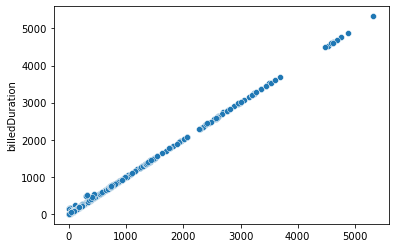

In [154]:
sns.scatterplot(data=df, x=df["endTimestamp"]-df["startTimestamp"], y="billedDuration")

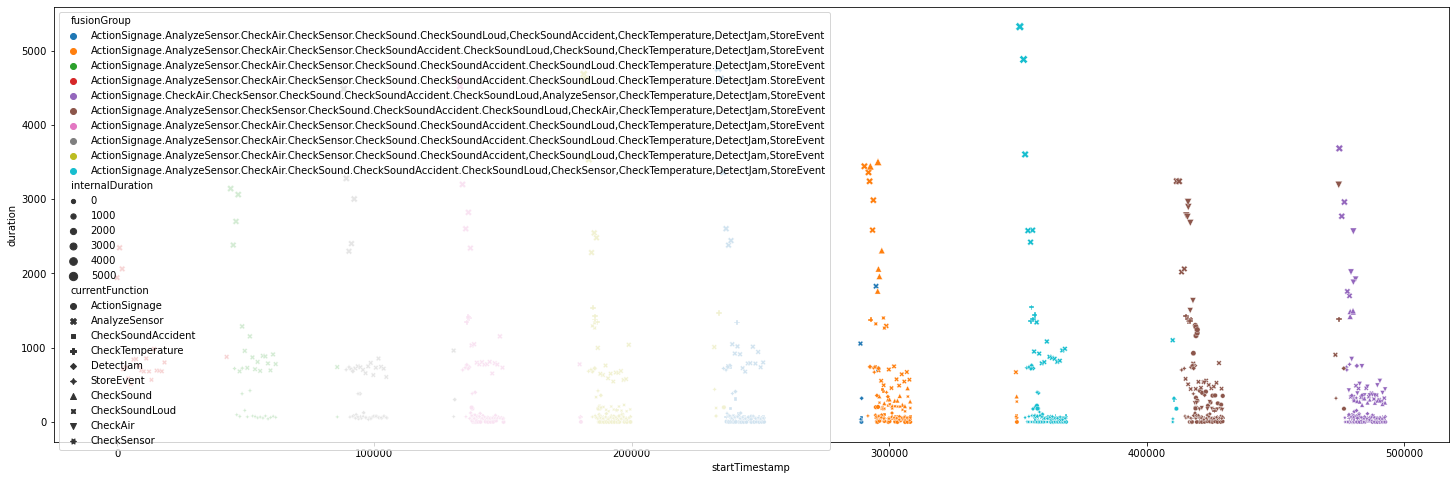

In [155]:
plt.figure(figsize=(25,8))
sns.scatterplot(data=df, x="startTimestamp", y="duration", size="internalDuration", hue=df["fusionGroup"], style="currentFunction")
plt.savefig("pointCloud.pdf")

<AxesSubplot:xlabel='startTimestamp', ylabel='10s_billedDuration_avg'>

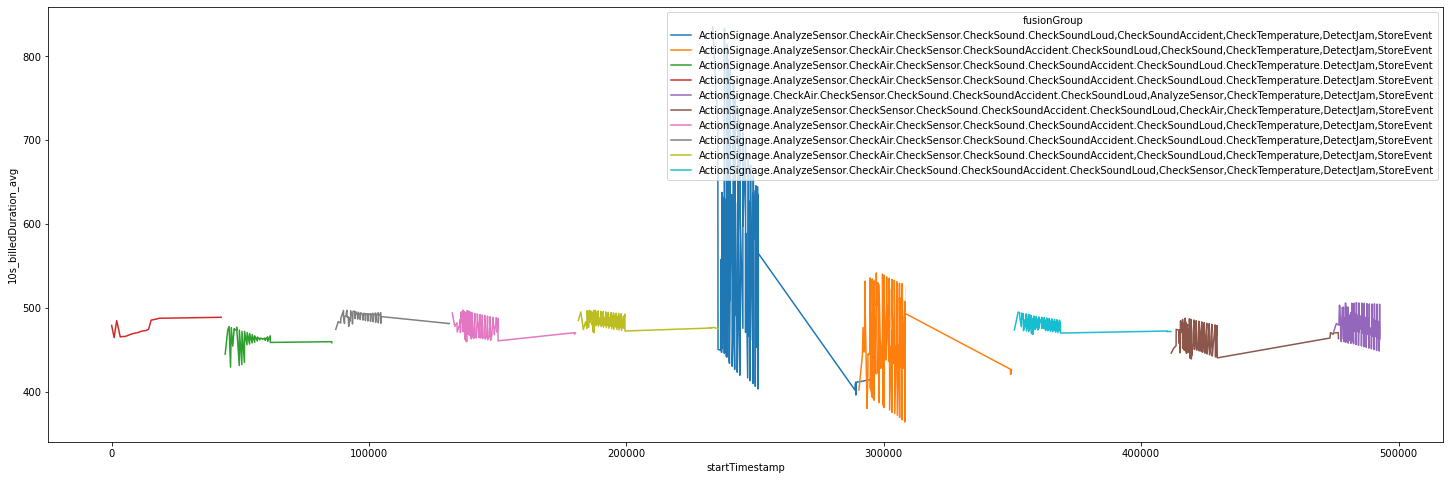

In [156]:
plt.figure(figsize=(25,8))
df['10s_billedDuration_avg'] = df['billedDuration'].rolling(10000, min_periods=30).mean()
#df['10s_billedDuration_med'] = df['billedDuration'].rolling(10000, min_periods=30).median()
sns.lineplot(data=df, x="startTimestamp", y="10s_billedDuration_avg", hue=df["fusionGroup"])
#sns.lineplot(data=df, x="startTimestamp", y="10s_billedDuration_med", hue=df["fusionGroup"])
#sns.scatterplot(data=df, x="startTimestamp", y="billedDuration", hue=df["fusionGroup"], legend=None)

In [157]:
# Now do not count every invocation, but sort the df by the cost of trace
grouped = df.groupby('traceId').agg({'billedDuration': ['sum'], 'startTimestamp': ['min'], 'endTimestamp': ['max'], 'fusionGroup': 'min'})
#grouped['numInvocations'] = df.groupby('traceId').count()
grouped['numInvocations'] = df.groupby('traceId').size()
print(f'Total Number of Invocations should be: {grouped["numInvocations"].sum()} == {len(df.index)}')

# Grouped: Get Root Invocation of TraceId and get rootEndTimestamp
# Pandas join() oder merge() machen mit dem alten Dataframe. Merge ist einfacher
rootInvocations = df[df["isRootInvocation"]][["traceId", "endTimestamp"]].rename(columns={"endTimestamp": "rootEndTimestamp"})
grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")
grouped["rootDuration"] = grouped["rootEndTimestamp"] - grouped["startTimestamp", "min"]

grouped

Total Number of Invocations should be: 1008 == 1008


/tmp/ipykernel_21038/2807751757.py:10: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")


,traceId,"(billedDuration, sum)","(startTimestamp, min)","(endTimestamp, max)","(fusionGroup, min)","(numInvocations, )",rootEndTimestamp,rootDuration
0,01a74405ab7d29ac6676338b90a57a360717a226a88f14...,1365,420131,421169,ActionSignage.AnalyzeSensor.CheckSensor.CheckS...,7,420672,541
1,04ceac6b314a4f6b6e3142b6416eed0889c190120a0e17...,1418,299844,300551,ActionSignage.AnalyzeSensor.CheckAir.CheckSens...,7,300551,707
2,0609d60575da48cbefcc1f1c9f276cf2103e27aa591452...,1225,492341,493087,ActionSignage.CheckAir.CheckSensor.CheckSound....,8,492663,322
3,070a94e56115eb4183621fb8c2f62a9dee44bdb38e2318...,1128,488333,489008,ActionSignage.CheckAir.CheckSensor.CheckSound....,8,488643,310
4,0744c8e58c372fb81ad6ca69970b7845ebfac972c0e978...,993,141756,143181,ActionSignage.AnalyzeSensor.CheckAir.CheckSens...,5,142562,806
...,...,...,...,...,...,...,...,...
195,f5fb1cccf9ddb24471ba1bb70e90188aaf7dd9f46c8408...,1225,358253,359174,ActionSignage.AnalyzeSensor.CheckAir.CheckSoun...,6,359174,921
196,f766f8c7c24c8f14dd8afab099aec871177b4a08c1c454...,1191,297835,298330,ActionSignage.AnalyzeSensor.CheckAir.CheckSens...,7,298330,495
197,f7a48fcb6a9b1e971ee3ab30d37ff76ed97fa228707e3a...,4450,296856,299402,ActionSignage.AnalyzeSensor.CheckAir.CheckSens...,8,297411,555
198,fa58507a7aaccc10d61006a069967ff0e58bd18acf0062...,1036,364258,365110,ActionSignage.AnalyzeSensor.CheckAir.CheckSoun...,6,365110,852


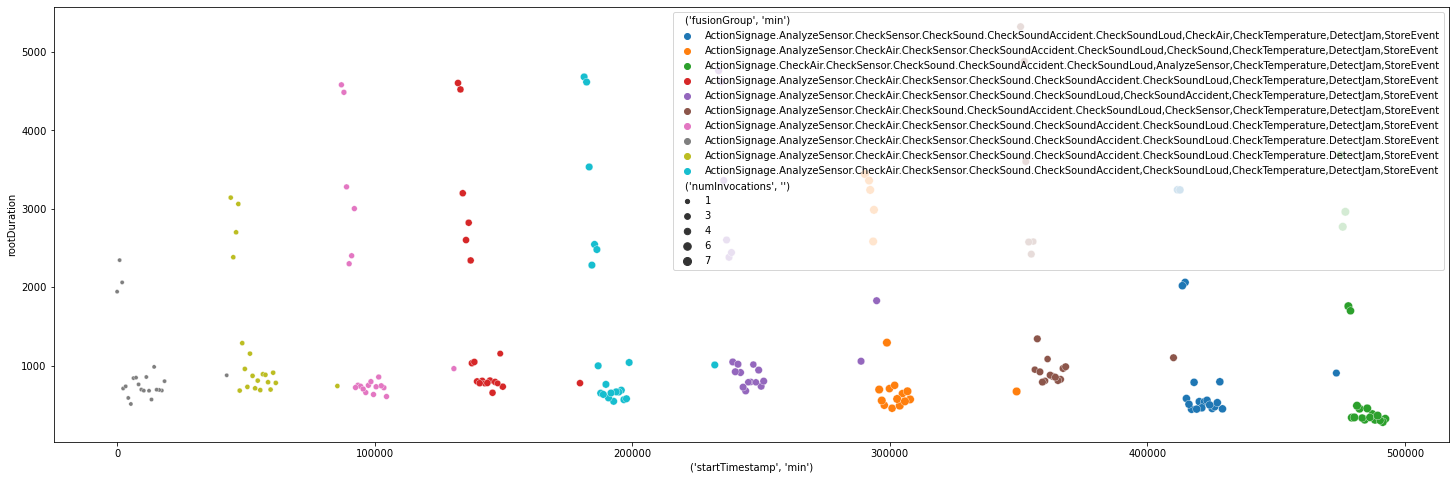

In [158]:
plt.figure(figsize=(25,8))
sns.scatterplot(data=grouped, x=grouped['startTimestamp', 'min'] , y=grouped['rootDuration'], hue=grouped['fusionGroup', 'min'], size=grouped["numInvocations", ""])
plt.savefig("duration.pdf")

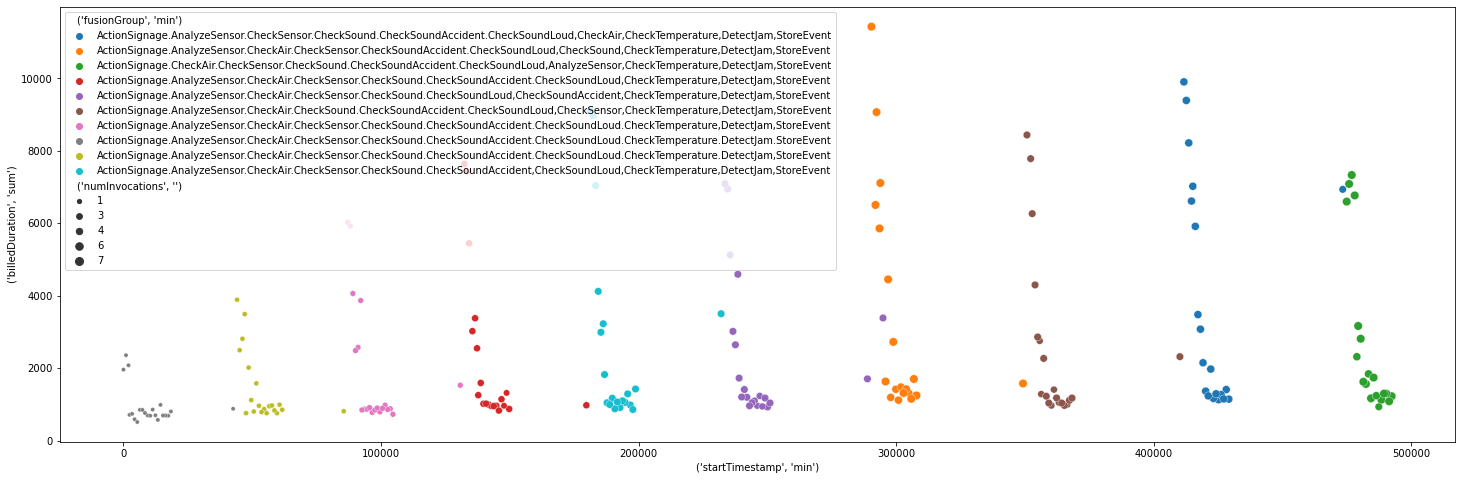

In [159]:
plt.figure(figsize=(25,8))
sns.scatterplot(data=grouped, x=grouped['startTimestamp', 'min'] , y=grouped['billedDuration', 'sum'], hue=grouped['fusionGroup', 'min'], size=grouped["numInvocations", ""])
plt.savefig("billed.pdf")

['ActionSignage.AnalyzeSensor.CheckAir.CheckSensor.CheckSound.CheckSoundAccident.CheckSoundLoud.CheckTemperature.DetectJam.StoreEvent'
 'ActionSignage.AnalyzeSensor.CheckAir.CheckSensor.CheckSound.CheckSoundAccident.CheckSoundLoud.CheckTemperature.DetectJam,StoreEvent'
 'ActionSignage.AnalyzeSensor.CheckAir.CheckSensor.CheckSound.CheckSoundAccident.CheckSoundLoud.CheckTemperature,DetectJam,StoreEvent'
 'ActionSignage.AnalyzeSensor.CheckAir.CheckSensor.CheckSound.CheckSoundAccident.CheckSoundLoud,CheckTemperature,DetectJam,StoreEvent'
 'ActionSignage.AnalyzeSensor.CheckAir.CheckSensor.CheckSound.CheckSoundAccident,CheckSoundLoud,CheckTemperature,DetectJam,StoreEvent'
 'ActionSignage.AnalyzeSensor.CheckAir.CheckSensor.CheckSound.CheckSoundLoud,CheckSoundAccident,CheckTemperature,DetectJam,StoreEvent'
 'ActionSignage.AnalyzeSensor.CheckAir.CheckSensor.CheckSoundAccident.CheckSoundLoud,CheckSound,CheckTemperature,DetectJam,StoreEvent'
 'ActionSignage.AnalyzeSensor.CheckAir.CheckSound.Check

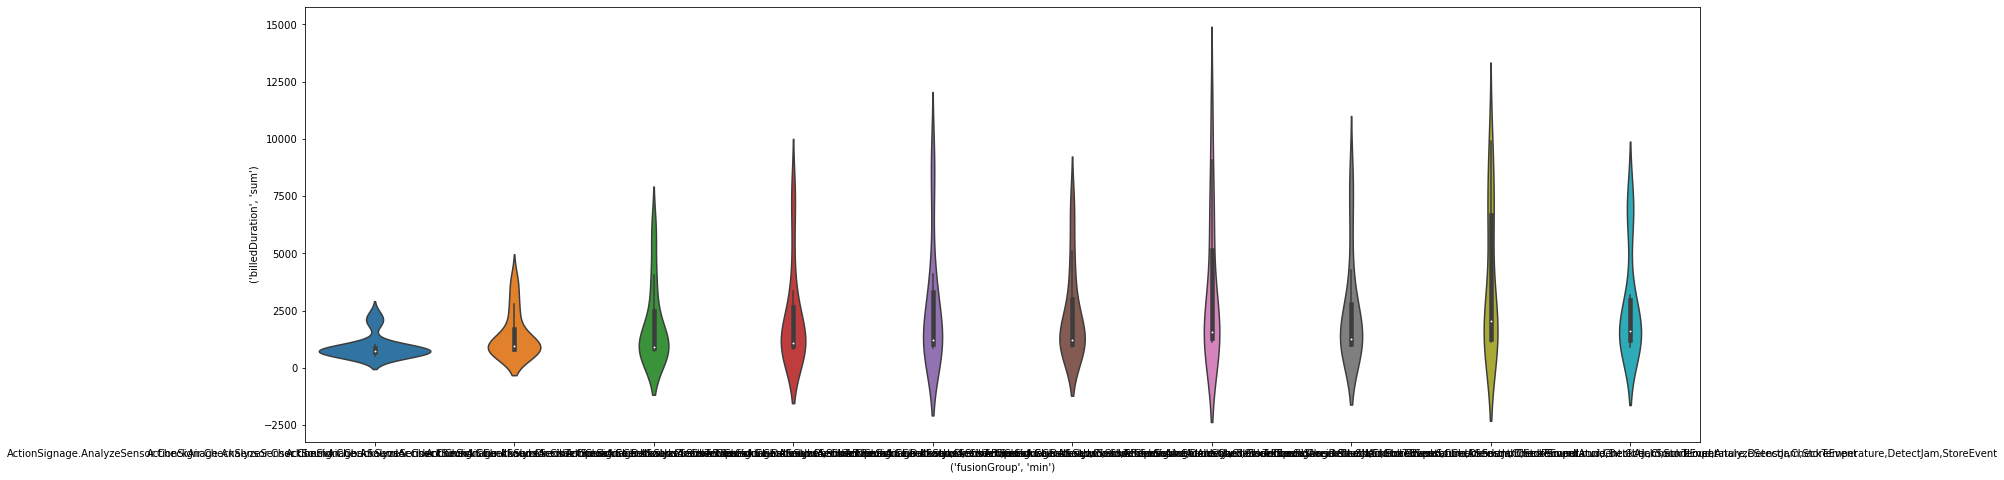

In [160]:
plt.figure(figsize=(25,8))
fusion_groups_order = pd.unique(grouped.sort_values(by="rootEndTimestamp")['fusionGroup', 'min'])
print(fusion_groups_order)
sns.violinplot(data=grouped, x=grouped['fusionGroup', 'min'] , y=grouped['billedDuration', 'sum'], order=fusion_groups_order)
plt.savefig("violinBilled.pdf")

['ActionSignage.AnalyzeSensor.CheckAir.CheckSensor.CheckSound.CheckSoundAccident.CheckSoundLoud.CheckTemperature.DetectJam.StoreEvent'
 'ActionSignage.AnalyzeSensor.CheckAir.CheckSensor.CheckSound.CheckSoundAccident.CheckSoundLoud.CheckTemperature.DetectJam,StoreEvent'
 'ActionSignage.AnalyzeSensor.CheckAir.CheckSensor.CheckSound.CheckSoundAccident.CheckSoundLoud.CheckTemperature,DetectJam,StoreEvent'
 'ActionSignage.AnalyzeSensor.CheckAir.CheckSensor.CheckSound.CheckSoundAccident.CheckSoundLoud,CheckTemperature,DetectJam,StoreEvent'
 'ActionSignage.AnalyzeSensor.CheckAir.CheckSensor.CheckSound.CheckSoundAccident,CheckSoundLoud,CheckTemperature,DetectJam,StoreEvent'
 'ActionSignage.AnalyzeSensor.CheckAir.CheckSensor.CheckSound.CheckSoundLoud,CheckSoundAccident,CheckTemperature,DetectJam,StoreEvent'
 'ActionSignage.AnalyzeSensor.CheckAir.CheckSensor.CheckSoundAccident.CheckSoundLoud,CheckSound,CheckTemperature,DetectJam,StoreEvent'
 'ActionSignage.AnalyzeSensor.CheckAir.CheckSound.Check

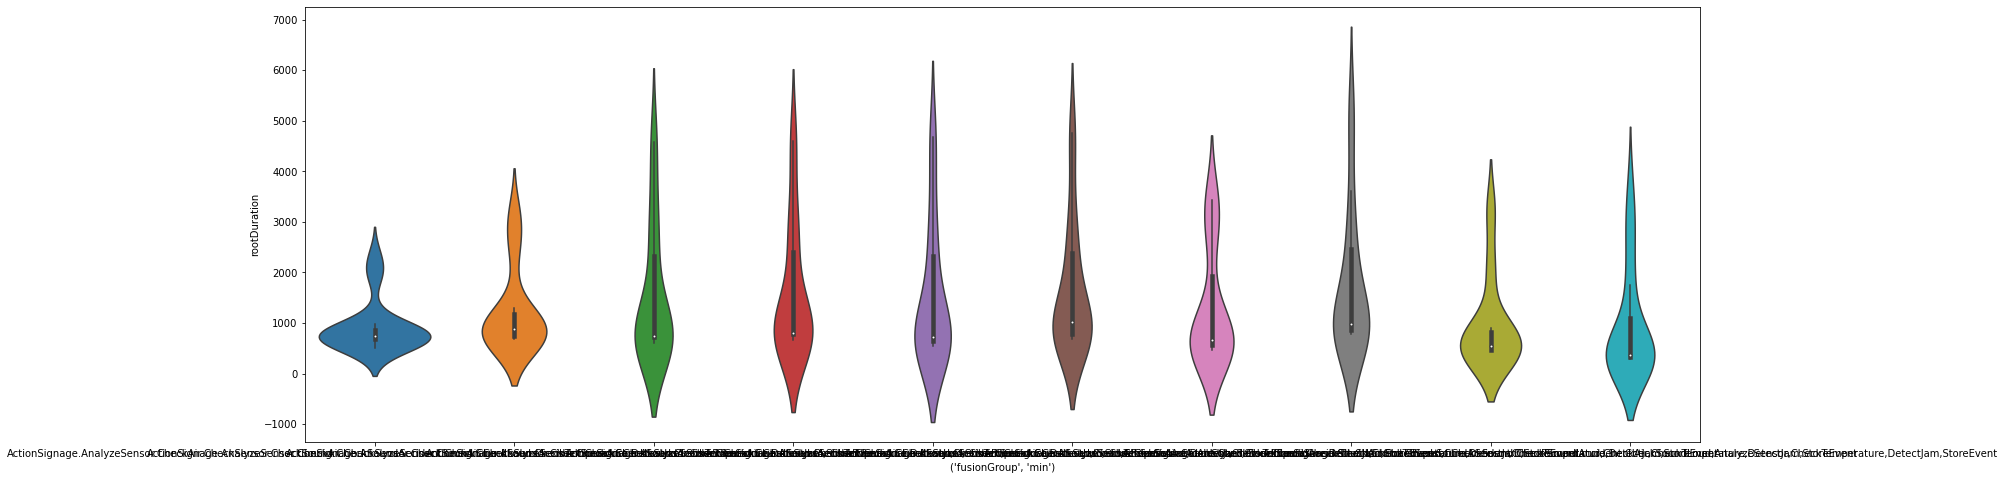

In [161]:
plt.figure(figsize=(25,8))
fusion_groups_order = pd.unique(grouped.sort_values(by="rootEndTimestamp")['fusionGroup', 'min'])
print(fusion_groups_order)
sns.violinplot(data=grouped, x=grouped['fusionGroup', 'min'] , y=grouped['rootDuration'], order=fusion_groups_order)
plt.savefig("violinRR.pdf")